In [1]:
import zipfile
import os
import glob
import chardet
import string
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from elasticsearch import Elasticsearch
from subprocess import Popen, PIPE, STDOUT
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91996\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91996\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
stemmer = PorterStemmer()

In [6]:
def extract_dataset():
  zip_file_path = 'archive.zip'
  os.makedirs('Dataset')
  extracted_folder_path = 'Dataset'

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

  print(f'Folder "{extracted_folder_path}" has been successfully unzipped.')


In [7]:
extract_dataset()

Folder "Dataset" has been successfully unzipped.


In [6]:
directory_path = 'Dataset'

extracted_data = []
no_files = 5
curr_file = 0

for file_path in glob.glob(os.path.join(directory_path, '*.txt')):
  # if curr_file == no_files: break
  try:
    encoding='utf-8'
    with open(file_path, 'rb') as file:
      encoding = chardet.detect(file.read())['encoding']
    with open(file_path, 'r', encoding=encoding) as file:
      file_content = file.read()
      extracted_data.append(file_content)
      # curr_file += 1
  except Exception as e:
    print(f"Error reading file {file_path}: {str(e)}")

print(f"Extracted data from {len(extracted_data)} files")


Extracted data from 20 files


In [6]:
def clean_and_preprocess_text(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

In [8]:
def stem_stopword_removal(text):
    return [stemmer.stem(word) for word in text if word not in stop_words]

In [9]:
categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc'
]

newsgroups = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
documents = newsgroups.data
categories = newsgroups.target_names

In [10]:
extracted_data = [text.split('.') for text in extracted_data] #dividing text of a document into list of sentences
extracted_data = [[clean_and_preprocess_text(sentence) for sentence in text] for text in extracted_data] # preprocessing sentences
extracted_data = [[tokenize_text(sentence) for sentence in text]for text in extracted_data] # tokenizing sentences
extracted_data = [[[word for word in sentence if word not in stop_words] for sentence in text] for text in extracted_data] # removing stopwords
extracted_data = [[[stemmer.stem(word) for word in sentence] for sentence in text] for text in extracted_data] # stemming the words

NameError: name 'extracted_data' is not defined

In [12]:
sentences = [sentence for text in extracted_data for sentence in text]

In [13]:
def train_model():
  model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
  model.save("word2vec_model.model")

In [14]:
train_model()

In [10]:
model = Word2Vec.load("word2vec_model.model")

In [12]:
document_texts = [[' '.join(sentence) for sentence in text] for text in extracted_data]
document_texts = [' '.join(text) for text in document_texts]
document_texts = [text.split() for text in document_texts]

In [11]:
document_texts = [text for text in documents]
document_texts = [clean_and_preprocess_text(text) for text in document_texts]
document_texts = [tokenize_text(text) for text in document_texts]
document_texts = [[stemmer.stem(word) for word in text if word not in stop_words] for text in document_texts]

In [12]:
number_of_documents = len(document_texts)
document_vectors = [[0] * model.vector_size for i in range(number_of_documents)]

In [35]:
for i, document_tokens in enumerate(document_texts):
  word_count = 0
  for token in document_tokens:
    if token in model.wv:
      document_vectors[i] = [x + y for x, y in zip(document_vectors[i], model.wv[token])]
      word_count += 1

  if word_count > 0:
    document_vectors[i] = [x / word_count for x in document_vectors[i]]

In [13]:
document_texts = [' '.join(text) for text in document_texts]

In [14]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

In [15]:
index_name= 'vsm_news'

In [49]:
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name)

for i, text in enumerate(documents):
  doc_vector = {
      'text': text,
      'vector': document_vectors[i]
  }
  es.index(index=index_name, id=i, body=doc_vector)

C:\Users\91996\AppData\Local\Temp\ipykernel_25028\436320218.py:9: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index=index_name, id=i, body=doc_vector)


In [16]:
def get_vector(tokens):
    vector = [0] * model.vector_size
    word_count = 0
    for token in tokens:
        if token in model.wv:
            vector = [x + y for x, y in zip(vector, model.wv[token])]
            word_count += 1
    
    if word_count > 0:
        vector = [x / word_count for x in vector]
    return vector

In [17]:
def get_cosine_similarity_query(vector):
    return  {
        "query": {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": "cosineSimilarity(params.query_vector, 'vector') + 1.0",
                    "params": {
                        "query_vector": vector
                    }
                }
            }
        }, 
        "size": 100
    }

In [18]:
def is_relevant(doc, qry):
    unique_tokens = list(set(qry))
    cnt = 0
    for token in unique_tokens:
        if token in doc: cnt += 1
    return cnt >= (1 * len(unique_tokens) / 3)

C:\Users\91996\AppData\Local\Temp\ipykernel_21236\3222758247.py:20: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  retrieved_result = es.search(index=index_name, body=get_cosine_similarity_query(qry_vector))


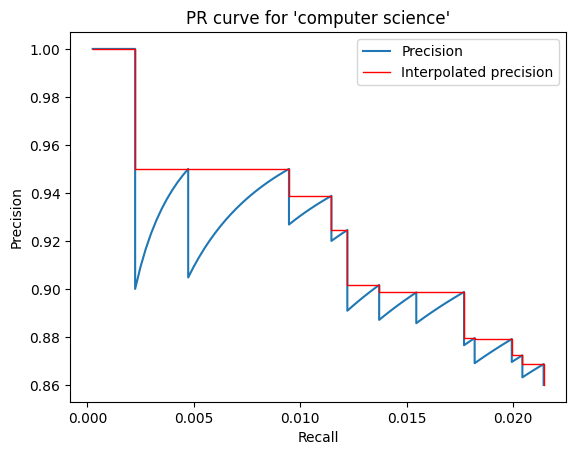

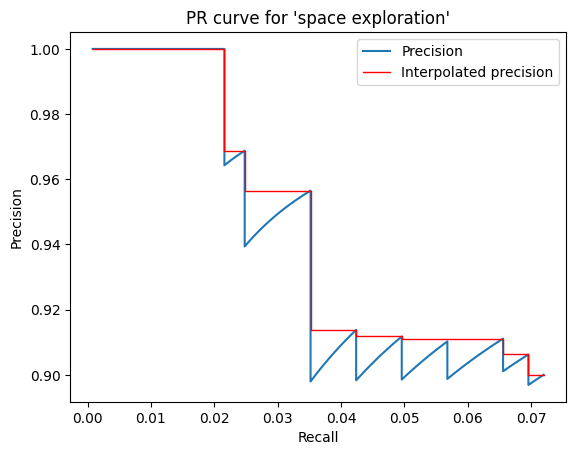

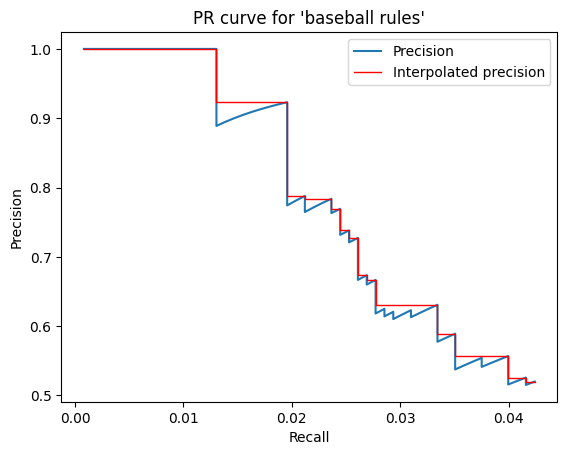

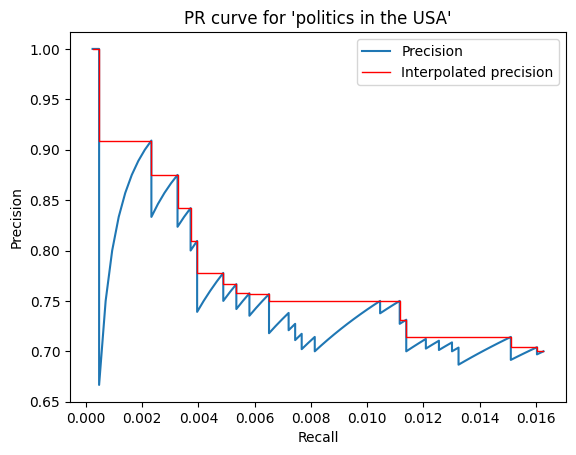

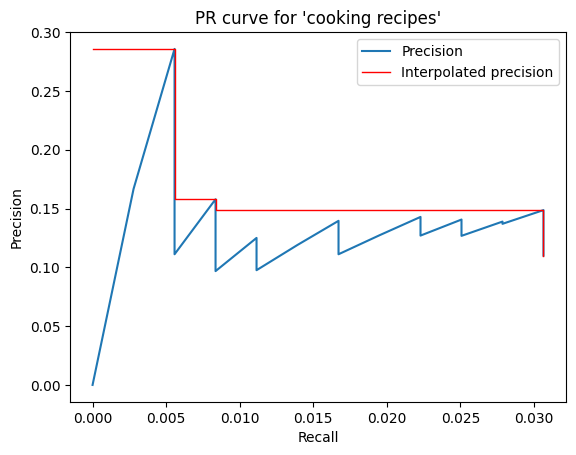

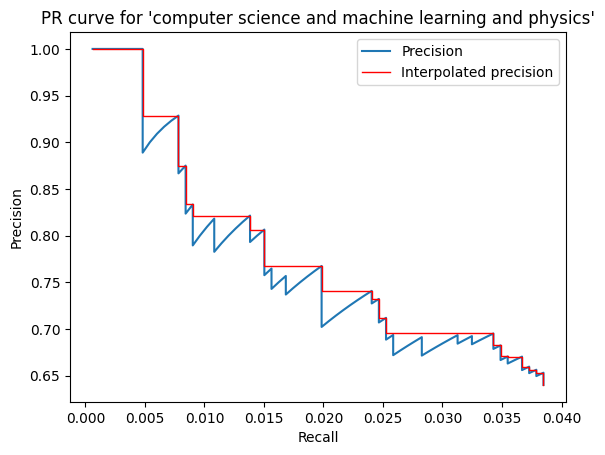

In [19]:
queries = [
    "computer science",
    "space exploration",
    "baseball rules",
    "politics in the USA",
    "cooking recipes",
    "computer science and machine learning and physics"
]

precision_values = [[] for i in range(len(queries))]
recall_values = [[] for i in range(len(queries))]
doc_scores = [[] for i in range(len(queries))]
total_retrieved_docs = [[] for i in range(len(queries))]
total_relevant_docs_retrieved = [[] for i in range(len(queries))]

for i, curr_query in enumerate(queries):
    preprocessed_query = stem_stopword_removal(word_tokenize(clean_and_preprocess_text(curr_query)))
    qry_vector = get_vector(preprocessed_query)
    
    retrieved_result = es.search(index=index_name, body=get_cosine_similarity_query(qry_vector))
    retrieved_docs = [int(doc['_id']) for doc in retrieved_result['hits']['hits']]
    doc_scores[i] = [doc['_score'] for doc in retrieved_result['hits']['hits']]
    relevant_docs = [i for i, doc in enumerate(document_texts) if is_relevant(doc, preprocessed_query)]
    total_retrieved_docs[i] = retrieved_docs
    total_relevant_docs_retrieved[i] = [doc for doc in retrieved_docs if doc in relevant_docs]
    
    for k in range(1, len(retrieved_docs) + 1):
        relevant_docs_retrieved = list(set(retrieved_docs[:k]) & set(relevant_docs))
        precision = len(relevant_docs_retrieved) / len(retrieved_docs[:k])
        recall = len(relevant_docs_retrieved) / len(relevant_docs)
        # print(f'precision: {precision}\tRecall: {recall}')
        precision_values[i].append(precision)
        recall_values[i].append(recall)
        
    interpolated_precision_values = [max(precision_values[i][k:]) for k in range(len(recall_values[i]))]
    plt.Figure()
    plt.plot(recall_values[i], precision_values[i], label='Precision')
    plt.plot(recall_values[i], interpolated_precision_values, label='Interpolated precision', color='red', linewidth=1)
    plt.title(f'PR curve for \'{curr_query}\'')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()    

In [20]:
MAP = 0
for j in range(len(queries)):
    MAP += sum(precision_values[j]) / len(precision_values[j])
MAP /= len(queries)
print(f'MAP : {MAP}')

MAP : 0.7011901164406998


In [21]:
Zk = 0
k = 10
for j in range(len(queries)):
    num_relevant_doc = 0
    for doc in total_retrieved_docs[j][:k]: 
        if doc in total_relevant_docs_retrieved[j]: num_relevant_doc += 1
    Zk += num_relevant_doc / min(k, len(total_retrieved_docs[j]))
Zk /= len(queries)

In [22]:
def calculate_NDCG(doc_scores, retrieved_documents,relevant_documents):
    DCG = 0
    for m in range(1, min(k, len(doc_scores)) + 1):
        relevance = 0
        if retrieved_documents[m-1] in relevant_documents:
            relevance = 1
        DCG += (pow(2, relevance) - 1) / np.log(1 + m)
    
    IDCG = 0
    for m in range(1, min(k, len(retrieved_documents)) + 1):
        IDCG += (pow(2, 1) - 1) / np.log(1 + m)
    ndcg = DCG / IDCG

    return ndcg

In [23]:
NDCG = 0
for j in range(len(queries)):
    NDCG += calculate_NDCG(doc_scores[j], total_retrieved_docs[j], total_relevant_docs_retrieved[j])
NDCG /= len(queries)       
print(f'NDCG : {NDCG}')

NDCG : 0.8186402160459424


Standard Keyword based search

In [24]:
def keyword_based_query(keyword: str):
    return {
        "query": {
            "match": {
                "text": keyword
            }
        }, 
        "size": 100
    }

In [30]:
import time

In [37]:
q = keyword_based_query('computer')
start = time.time()
res = es.search(index=index_name, body=keyword_based_query(' '.join(stem_stopword_removal(word_tokenize(clean_and_preprocess_text("computer of the modern era"))))))
end = time.time()
print(end-start)
len(res['hits']['hits'])

0.03902411460876465


C:\Users\91996\AppData\Local\Temp\ipykernel_21236\3344815576.py:3: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=index_name, body=keyword_based_query(' '.join(stem_stopword_removal(word_tokenize(clean_and_preprocess_text("computer of the modern era"))))))


100

In [38]:
# q = get_cosine_similarity_query(get_vector([stemmer.stem('computer t')]))
start = time.time()
res = es.search(index=index_name, body=get_cosine_similarity_query(get_vector(stem_stopword_removal(word_tokenize(clean_and_preprocess_text("computer of the modern era"))))))
end = time.time()
print(end-start)
len(res['hits']['hits'])

0.12276124954223633


C:\Users\91996\AppData\Local\Temp\ipykernel_21236\2815637672.py:3: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  res = es.search(index=index_name, body=get_cosine_similarity_query(get_vector(stem_stopword_removal(word_tokenize(clean_and_preprocess_text("computer of the modern era"))))))


100

C:\Users\91996\AppData\Local\Temp\ipykernel_21236\497277004.py:20: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  retrieved_result = es.search(index=index_name, body=keyword_based_query(preprocessed_query))


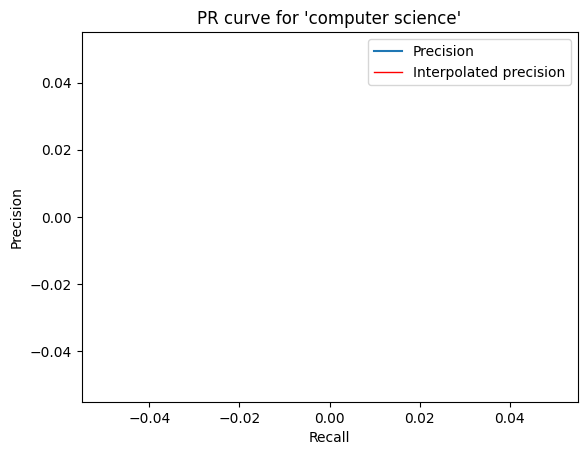

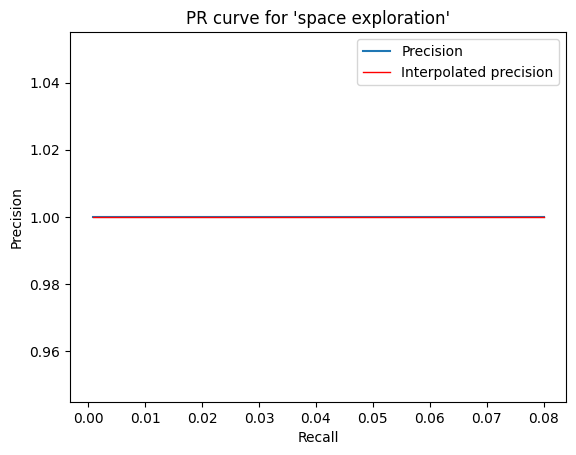

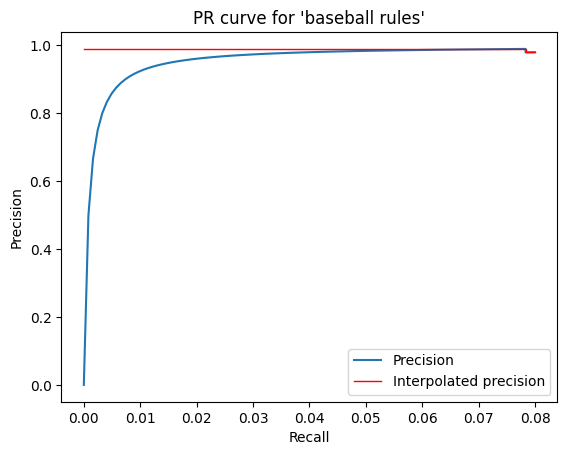

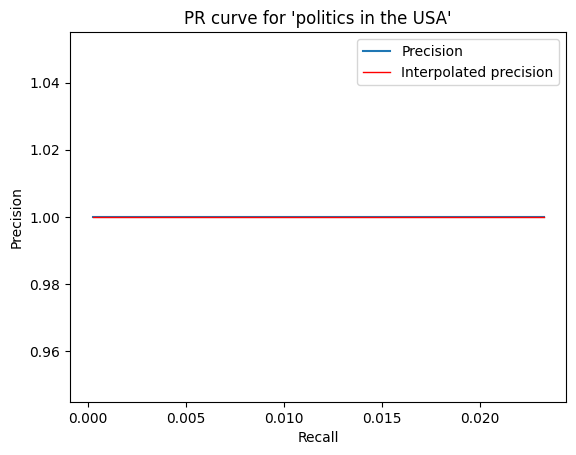

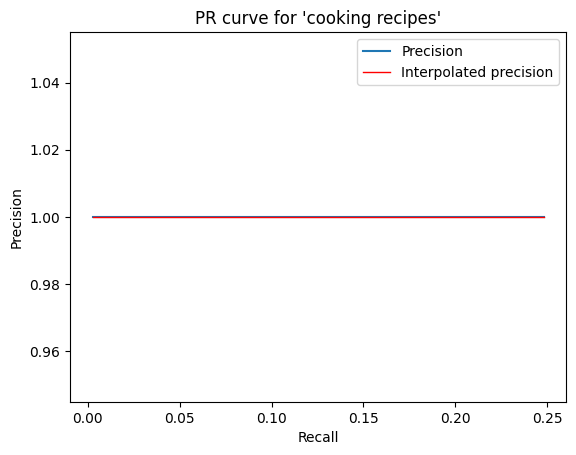

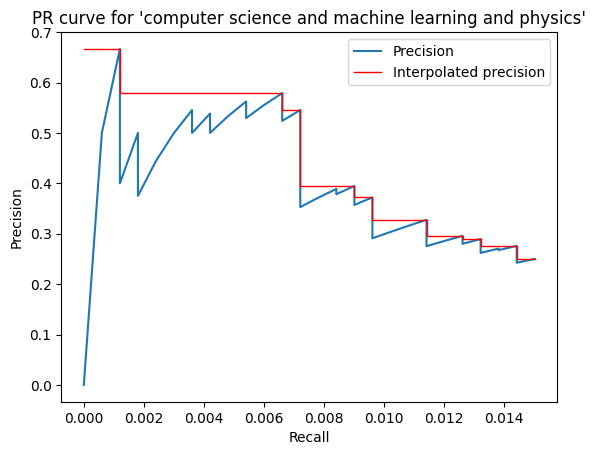

In [40]:
queries = [
    "computer science",
    "space exploration",
    "baseball rules",
    "politics in the USA",
    "cooking recipes",
    "computer science and machine learning and physics"
]

precision_values = [[] for i in range(len(queries))]
recall_values = [[] for i in range(len(queries))]
doc_scores = [[] for i in range(len(queries))]
total_retrieved_docs = [[] for i in range(len(queries))]
total_relevant_docs_retrieved = [[] for i in range(len(queries))]

for i, curr_query in enumerate(queries):
    preprocessed_query = stem_stopword_removal(word_tokenize(clean_and_preprocess_text(curr_query)))
    preprocessed_query = ' '.join(preprocessed_query)
    
    retrieved_result = es.search(index=index_name, body=keyword_based_query(preprocessed_query))
    
    retrieved_docs = [int(doc['_id']) for doc in retrieved_result['hits']['hits']]
    doc_scores[i] = [doc['_score'] for doc in retrieved_result['hits']['hits']]
    relevant_docs = [i for i, doc in enumerate(document_texts) if is_relevant(doc, preprocessed_query.split())]
    total_retrieved_docs[i] = retrieved_docs
    total_relevant_docs_retrieved[i] = [doc for doc in retrieved_docs if doc in relevant_docs]
    # if i == len(queries) - 1:
    #     print(doc_scores[i])
    if len(retrieved_docs) == 0:
        precision_values[i].append(0)
        recall_values[i].append(0)
    for k in range(1, len(retrieved_docs) + 1):
        relevant_docs_retrieved = list(set(retrieved_docs[:k]) & set(relevant_docs))
        precision = len(relevant_docs_retrieved) / len(retrieved_docs[:k])
        recall = len(relevant_docs_retrieved) / len(relevant_docs)
        precision_values[i].append(precision)
        recall_values[i].append(recall)
        
    interpolated_precision_values = [max(precision_values[i][k:]) for k in range(len(recall_values[i]))]
    plt.Figure()
    plt.plot(recall_values[i], precision_values[i], label='Precision')
    plt.plot(recall_values[i], interpolated_precision_values, label='Interpolated precision', color='red', linewidth=1)
    plt.title(f'PR curve for \'{curr_query}\'')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [41]:
MAP = 0
for j in range(len(queries)):
    MAP += sum(precision_values[j]) / len(precision_values[j])
MAP /= len(queries)
print(f'MAP : {MAP}')

MAP : 0.7175762203193373


In [1]:
print(f'MAP : {0.3125293142184413}')

MAP : 0.3125293142184413


In [2]:
print(f'NDCG : {0.3801246578325947}')

NDCG : 0.3801246578325947
